<a href="https://colab.research.google.com/github/con321dude/Side-Projects/blob/master/KoboldAssessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connor Hammock

Kobold Take Home Assessment

05/11/2023





In [ ]:
pip install geopandas numpy matplotlib  rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Packages used:

In [ ]:
import geopandas as gpd
import numpy as np

#Matplotlib:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#Shapely:
from shapely.ops import nearest_points
from shapely.geometry import Point, MultiPolygon

#Rasterio for rasterization:
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin


In [ ]:
INPUT_FILE = "/content/BedrockP.gpkg"
bedrock_data = gpd.read_file(INPUT_FILE)

In [ ]:
num_columns = len(bedrock_data.columns)
print("Number of Columns/Features:", num_columns)
print("------------------------------")
for column in bedrock_data.columns:
    print(column)

Number of Columns/Features: 28
------------------------------
gid
upid
area_m2
strat_unit
era
period
strat_age
strat_name
gp_suite
fm_lithodm
mem_phase
rock_class
rock_type
rk_char
unit_desc
age_max
age_min
belt
terrane
basin
basin_age
project
src_url
src_ref_s
map_comp
edit_date
pub_org
geometry


First step was to figure out which column/feature of the dataset was most significant, after looking through many features, I found that "rock_class" shows the two classes that are going to be used in determining cobalt formation.

<Axes: >

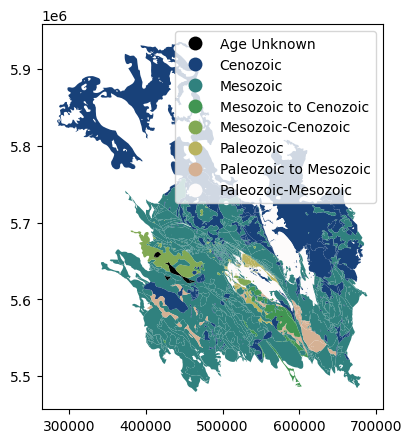

In [ ]:
bedrock_data.plot(column="era", categorical=True, legend=True, figsize=(5,5), cmap='gist_earth')

<Axes: >

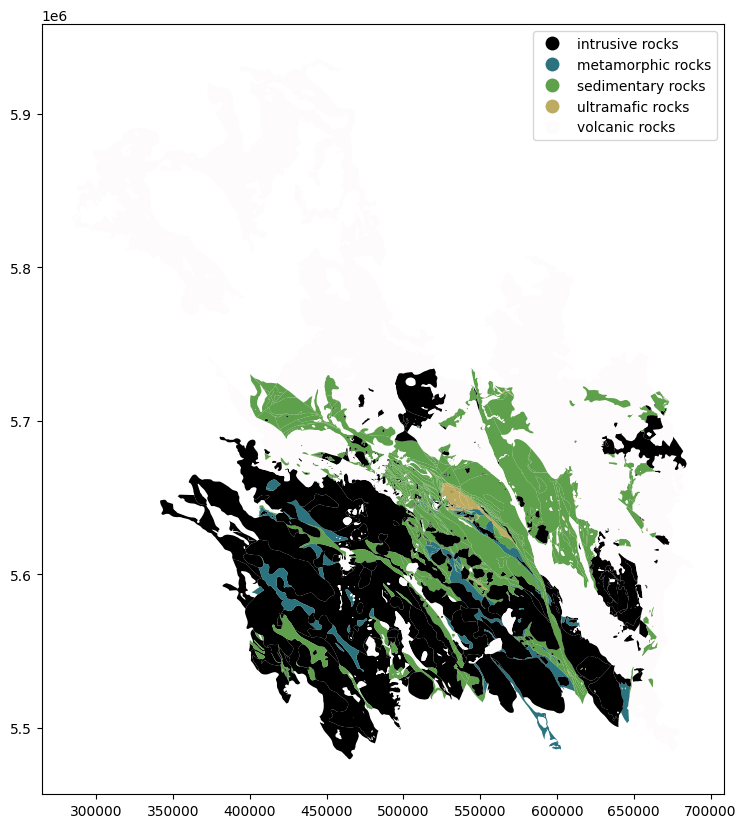

In [ ]:
bedrock_data.plot(column="rock_class", categorical=True, legend=True, figsize=
(10,10), cmap='gist_earth')

Showing only the two rock classes of interest:

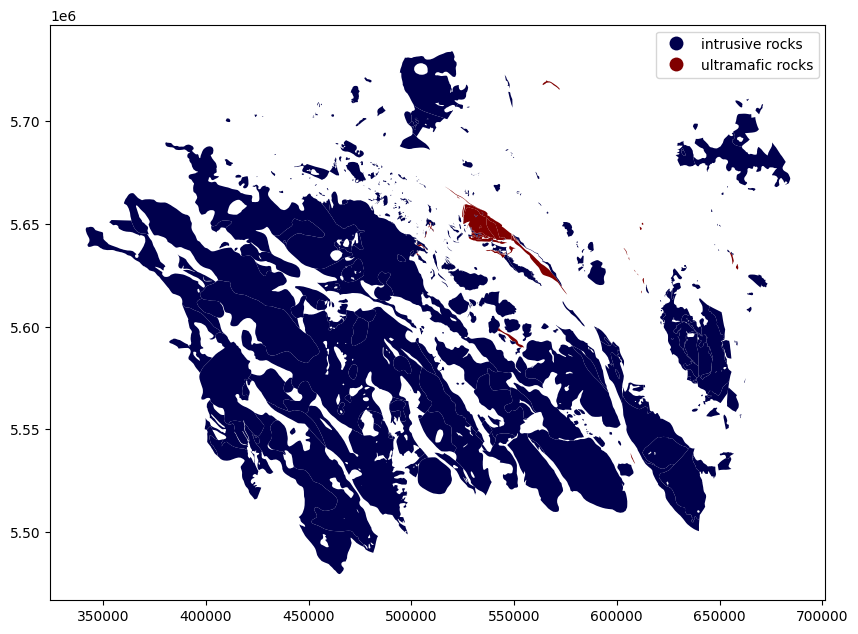

In [ ]:
both_data = bedrock_data[(bedrock_data["rock_class"] == "ultramafic rocks") | (bedrock_data["rock_class"] == "intrusive rocks")]

both_data.plot(column="rock_class", categorical=True, legend=True, figsize=(10,10), cmap='seismic')
plt.show()


If we create a 10km radius aroud all ultramafic rocks, this is the only regions that could potentially form Cobalt, since any area outside of this proximity would lie within a falloff distance. So we can preprocess the map to only have this proximity area to speed up future processing. 

"The buffer operation in GeoPandas (and in geospatial analysis in general) creates a polygon that encompasses all points within a given distance from any point in the original polygon. So when you call buffer(x) on a geometry, it expands the boundaries of the polygon outwards by x in all directions."

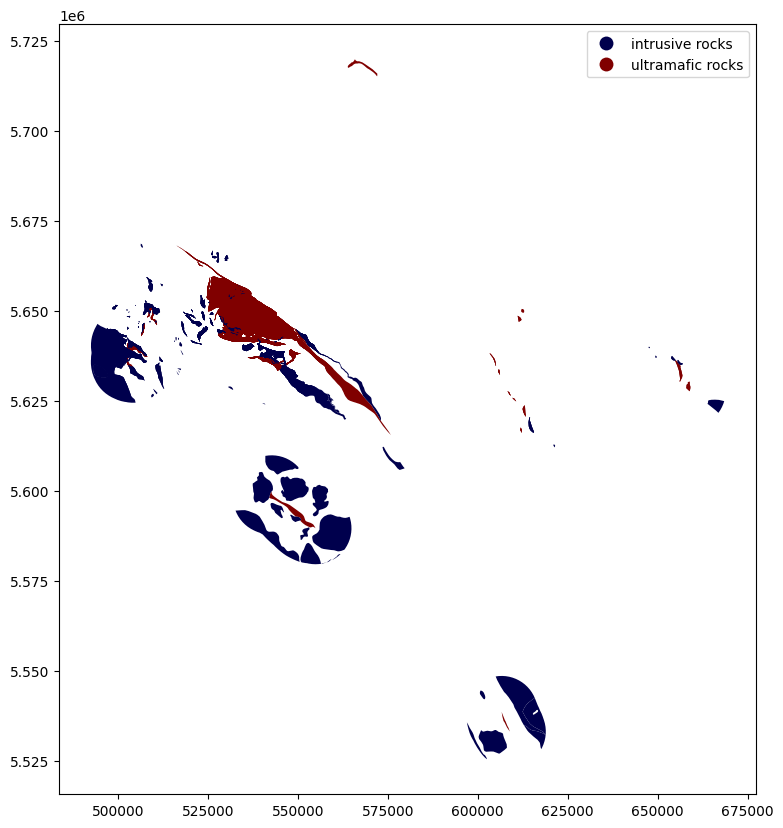

In [ ]:
#Select the two rock classes of interest:

ultramafic_data = bedrock_data[bedrock_data["rock_class"] == "ultramafic rocks"]
intrusive_data = bedrock_data[bedrock_data["rock_class"] == "intrusive rocks"]


#Buffer gemoetry
buffered_ultramafic = ultramafic_data.geometry.buffer(10000)  # 10km (in meters) from edges, not center
buffered_ultramafic_gdf = gpd.GeoDataFrame(geometry=buffered_ultramafic)

# Overlay the original data with the buffered data to get all points within 10km of ultramafic rocks
proximity_data = gpd.overlay(both_data, buffered_ultramafic_gdf, how='intersection')
proximity_data.plot(column="rock_class", categorical=True, legend=True, figsize=(10,10), cmap='seismic')
plt.show()


Calculate distance for each point in "proximity_data":

In [ ]:
# Preprocessing and heat map calculations
ultramafic_multipolygon = MultiPolygon(list(ultramafic_data.geometry))
intrusive_multipolygon = MultiPolygon(list(intrusive_data.geometry))
distance_to_ultramafic = np.zeros(len(proximity_data))
distance_to_intrusive = np.zeros(len(proximity_data))


for i, row in enumerate(proximity_data.geometry):
    distance_to_ultramafic[i] = ultramafic_multipolygon.distance(row)
    distance_to_intrusive[i] = intrusive_multipolygon.distance(row)

average_distance = (distance_to_ultramafic + distance_to_intrusive) / 2
heat_map_values = np.exp(-average_distance / 10000)  # Fall off distance is 10 km

#Create new column in proximitydata:
proximity_data["inverted_heat_map_value"] = heat_map_values

Create the raster:

In [ ]:
# Rasterization
resolution = 500  # Raster:  500 meters


"""
Bounds: 

bounds[0]: minx, the minimum x coordinate (longitude in geographic coordinates, often representing the westernmost point)
bounds[1]: miny, the minimum y coordinate (latitude in geographic coordinates, often representing the southernmost point)
bounds[2]: maxx, the maximum x coordinate (longitude in geographic coordinates, often representing the easternmost point)
bounds[3]: maxy, the maximum y coordinate (latitude in geographic coordinates, often representing the northernmost point)

"""
bounds = bedrock_data.total_bounds

#Width = (Max x - min x )/ resolution
width = int((bounds[2] - bounds[0]) / resolution)

#Height = (Max y - min y )/ resolution
height = int((bounds[3] - bounds[1]) / resolution)

#"Affine" transformation:
transform = from_origin(bounds[0], bounds[3], resolution, resolution)

#Create an empty raster:
raster = np.zeros((height, width)) 

for idx, row in proximity_data.iterrows(): #Get the raster from proximity data (which is the buffered data around ultramafic rocks)
    raster += rasterize([(row.geometry, row['inverted_heat_map_value'])], out_shape=(height, width), transform=transform, merge_alg=rasterio.enums.MergeAlg.add)

#Normalize raster: (Scale all values down to a range of 0 - 1)
raster = (raster - raster.min()) / (raster.max() - raster.min())

#Invert:
raster = 1 - raster



For each point on the raster, calculate the distance to each rock class, and then take the average of these two distances for use for the heatmap: 

(longest computational time)

In [ ]:

distance_to_ultramafic = np.zeros((height, width))
distance_to_intrusive = np.zeros((height, width))


#Go over each cell
for i in range(height): 
    for j in range(width):
        if raster[i, j] > 0: #if it is a relevant geographical feature (on the raster)
            point_coords = transform * (j, i) #Raster coordinates -> geographical coordinates
            point = Point(point_coords) #Create shapely Point from these coordinates

            #Calculate distance to nearest of each rock class for that location:
            distance_to_ultramafic[i, j] = ultramafic_multipolygon.distance(point)
            distance_to_intrusive[i, j] = intrusive_multipolygon.distance(point)

#For each cell, calculate average of the two distances:
average_distance = (distance_to_ultramafic + distance_to_intrusive) / 2 #(element-wise)


#Convert this average distance to a useful heatmap value:
heat_map_values = np.exp(-average_distance / 10000) #exponential decay e^(-x/a). x = avg distance, a = rate of decay


Plot the heatmap (only heatmap):

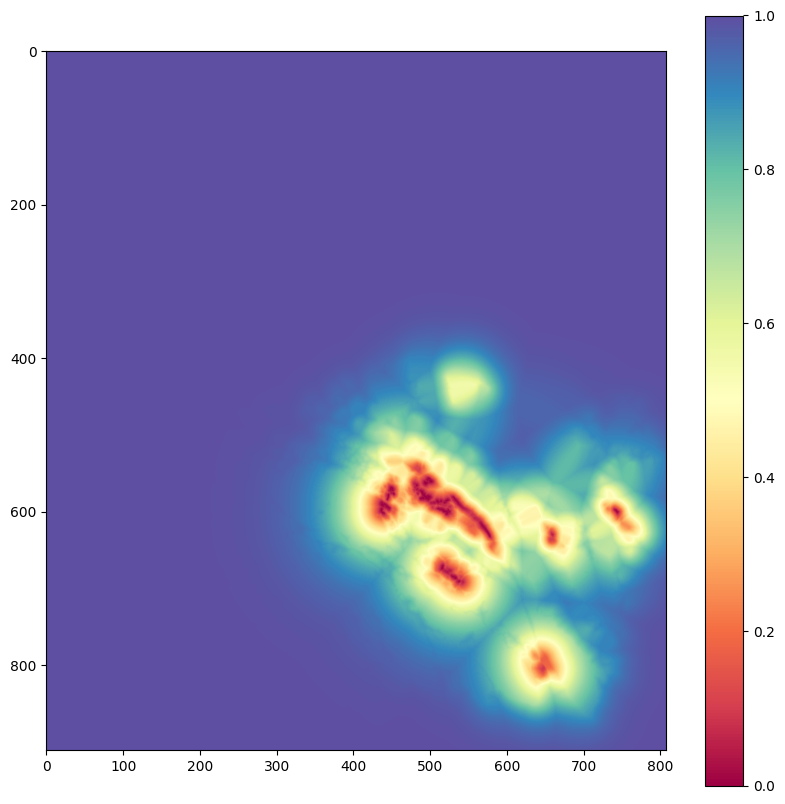

In [ ]:

inverted_heat_map_values = 1 - heat_map_values #invert the values so that green and red are correct


plt.figure(figsize=(10, 10))
plt.imshow(inverted_heat_map_values, cmap='Spectral')
plt.colorbar()
plt.show()


Now that we have the heatmap, we can create two rasters, for original map and heatmap.

In [ ]:
original_raster = np.zeros((height, width))
heatmap_raster = np.full((height, width), np.nan)

# Original map layer
for idx, row in bedrock_data.iterrows():
    original_raster += rasterize([(row.geometry, 1)], out_shape=(height, width), transform=transform)

# Heatmap layer
for idx, row in both_data.iterrows():
    heatmap_raster = np.nanmax([heatmap_raster, rasterize([(row.geometry, 1)], out_shape=(height, width), transform=transform)], axis=0)

# Since we want closer to be hotter, we need to invert the logic:
inverted_heat_map_values = np.where(np.isnan(heatmap_raster), 1, 1 - heat_map_values)



Then we can overlay both the heatmap and the original map on top of each other for our final map:

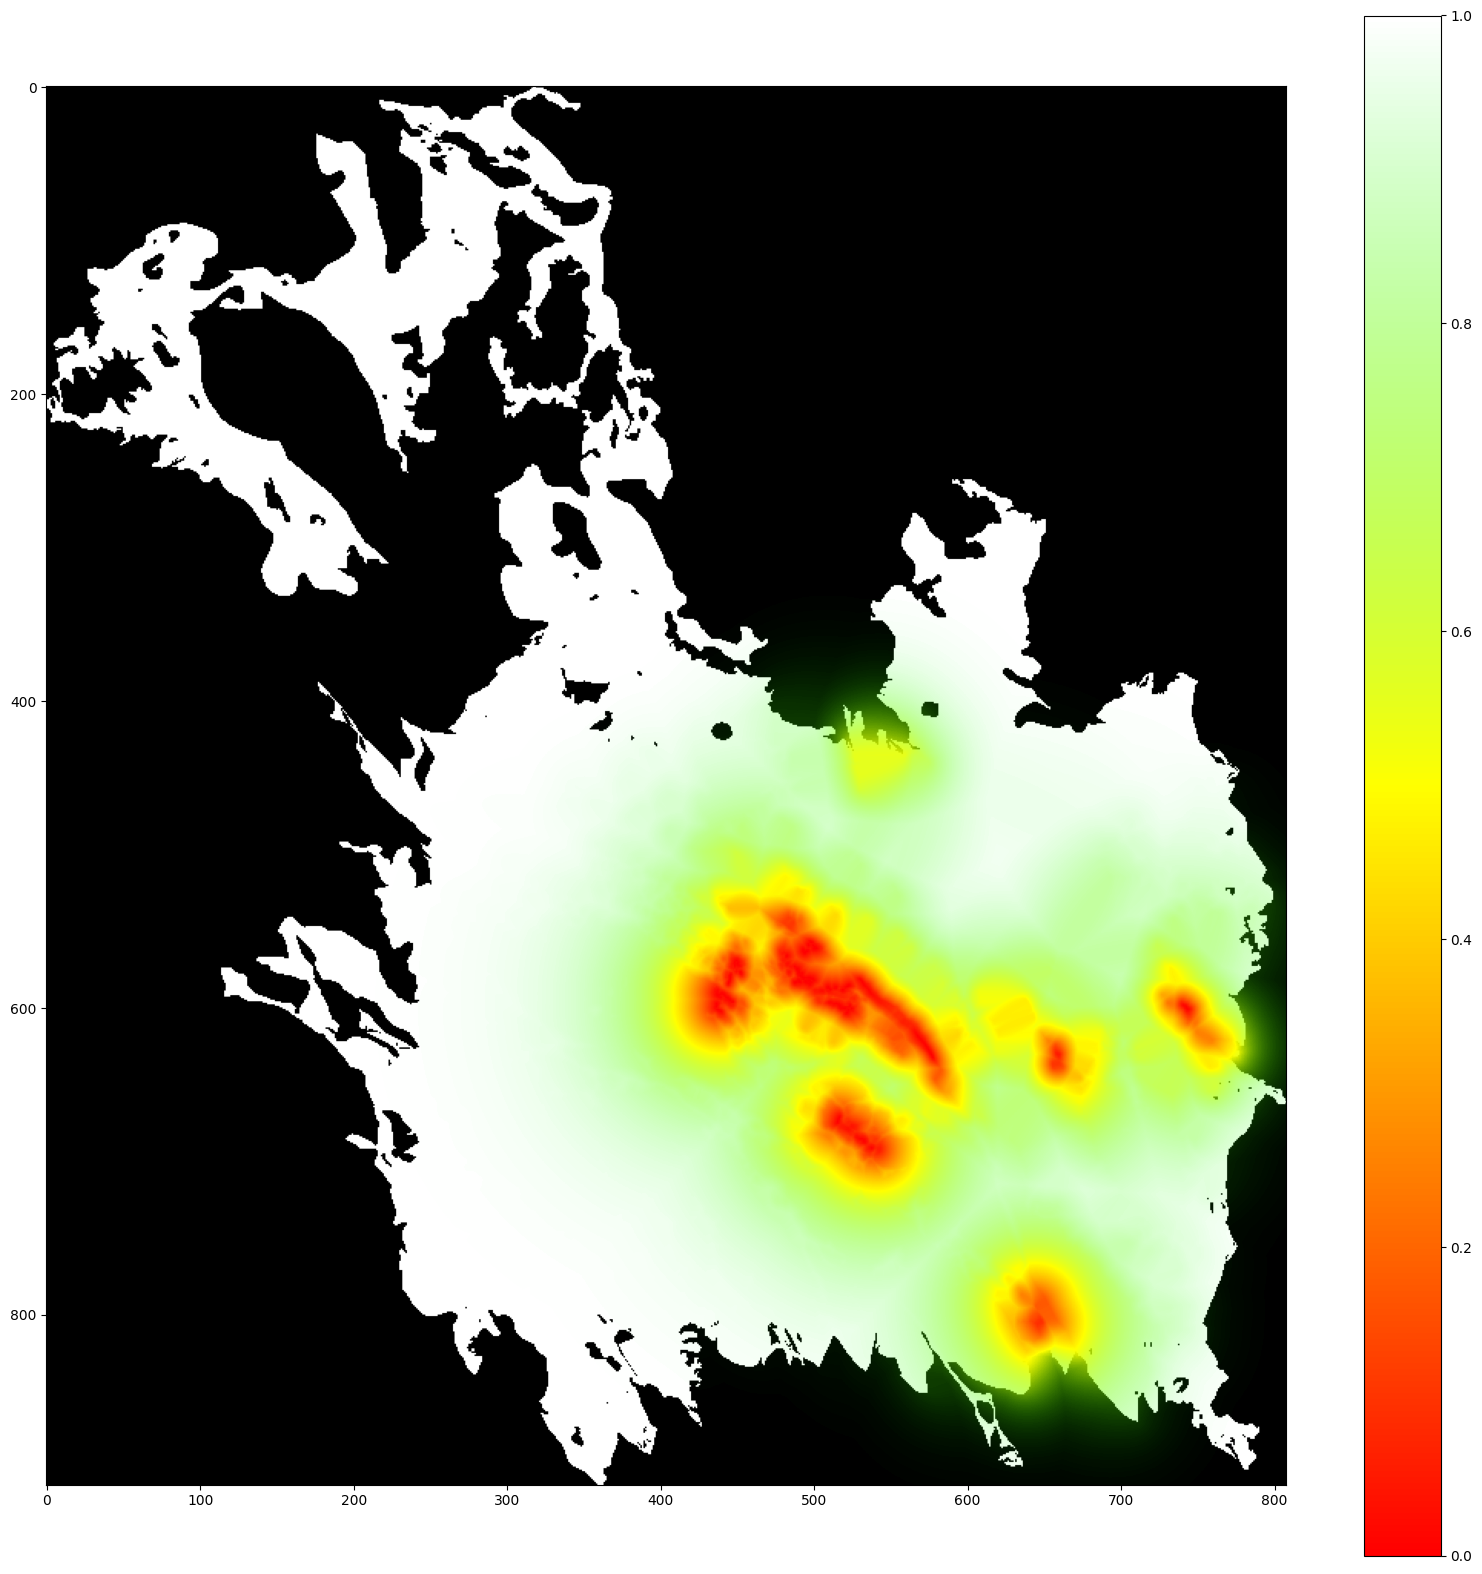

In [ ]:

# Custom heatmap, (0=red), (0.5 = yellow), (1 = transparent green)
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, "red"), (0.5, "yellow"), (1, (0, 1, 0, 0))]) #(0,1,0,0) = (RGBA), where G=1 and A (Alpha) = 0

# First: original map
plt.figure(figsize=(20, 20))

plt.imshow(original_raster, cmap='gray')

# Overlay the heatmap
plt.imshow(inverted_heat_map_values, cmap=cmap)

plt.colorbar()
plt.show()

A better visual would be the heatmap overlayed ontop of the both_data plot, showing both rock classes:

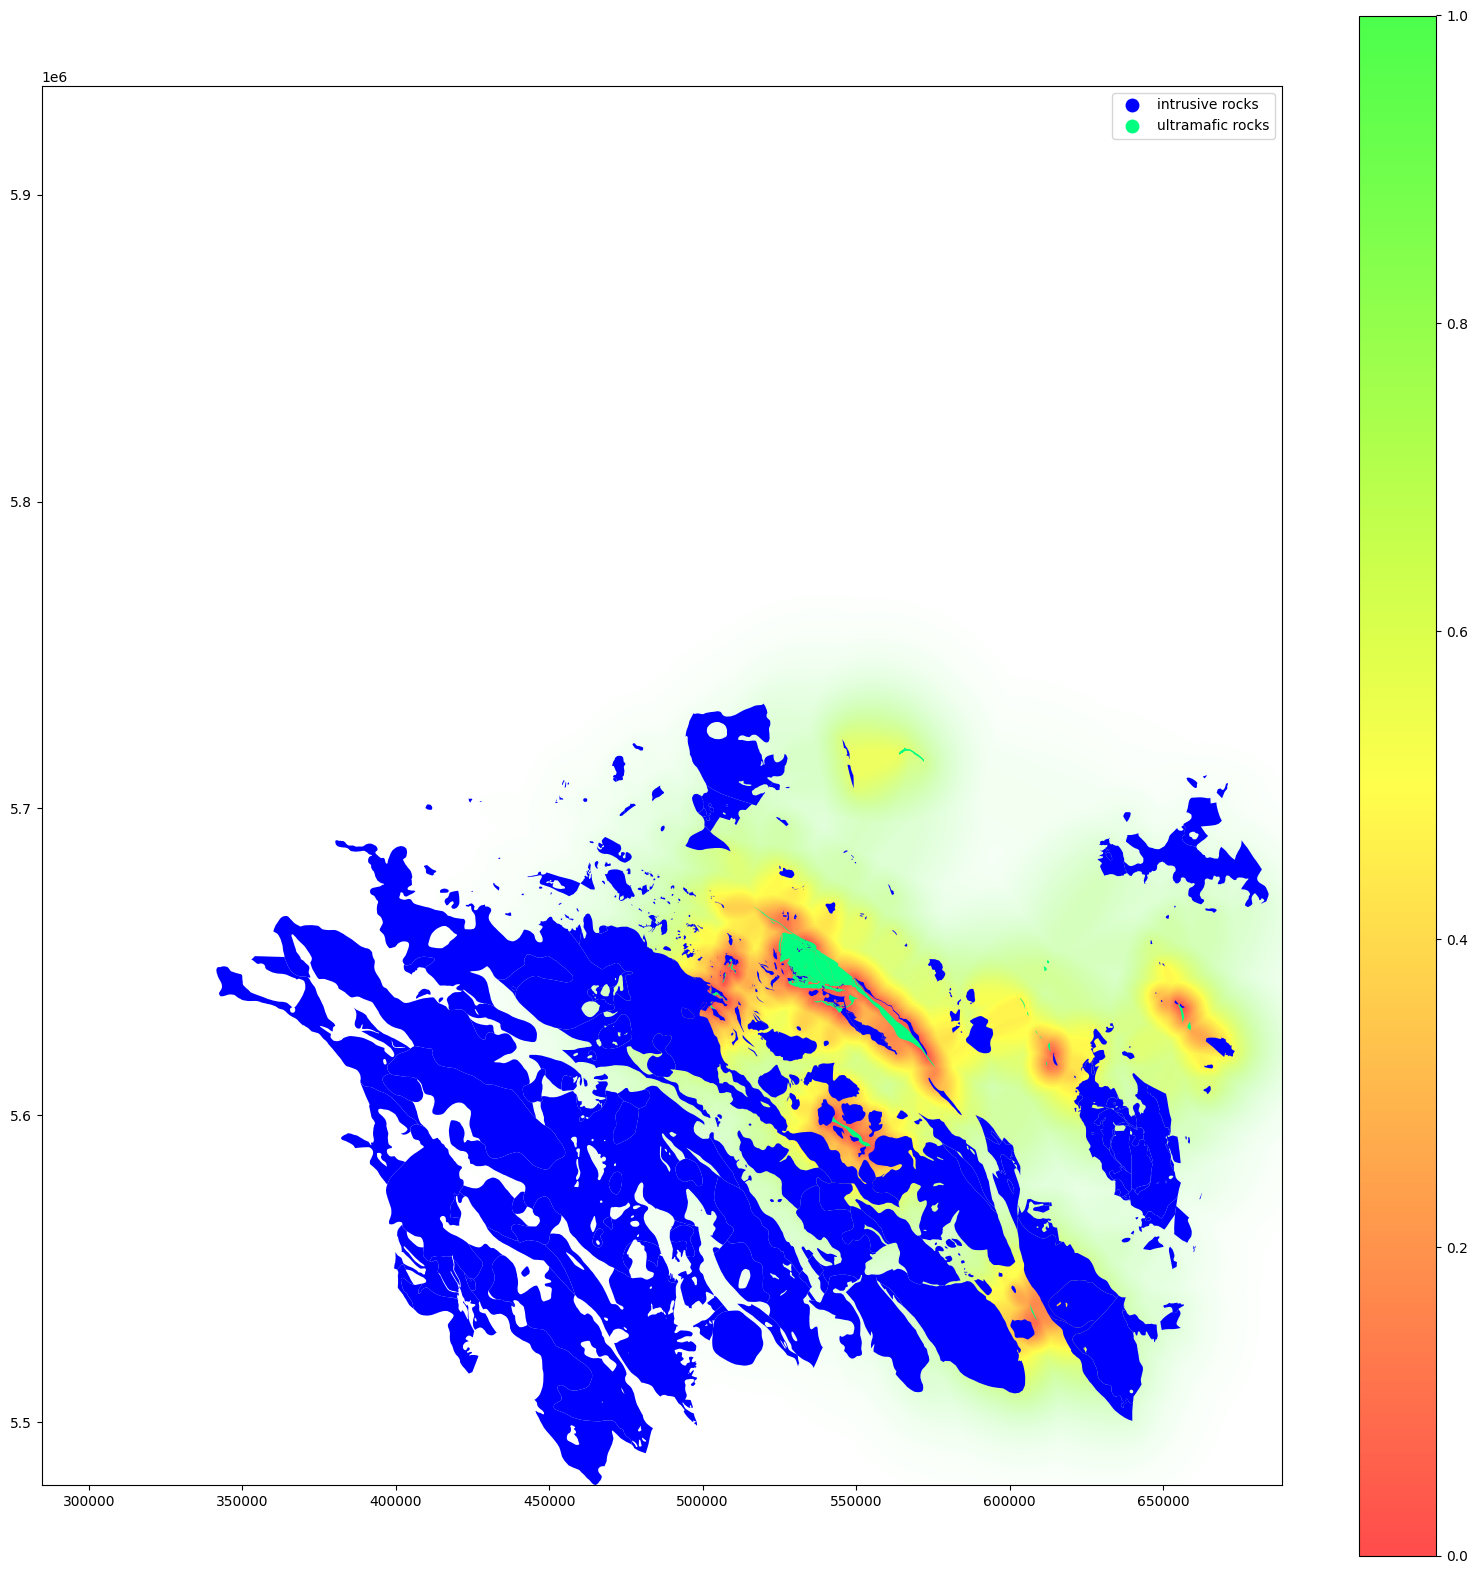

In [ ]:
# Custom heatmap, (0=red), (0.5 = yellow), (1 = transparent green)
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, "red"), (0.5, "yellow"), (1, (0, 1, 0, 0))]) #(0,1,0,0) = (RGBA), where G=1 and A (Alpha) = 0

# Bottom: original map with only two rock classes
fig, ax = plt.subplots(figsize=(20, 20))
both_data.plot(column="rock_class", categorical=True, legend=True, ax=ax, cmap='winter') #winter cmap seems to display all colors best

# Overlay the heatmap
# For imshow to align properly with the plot, we need to set the extent parameter:
extent=[bounds[0], bounds[2], bounds[1], bounds[3]] 

#Top image (heatmap)
im = ax.imshow(inverted_heat_map_values, cmap=cmap, extent=extent, alpha=0.7) # set alpha < 1 for transparency

fig.colorbar(im)
plt.show()

We can clearly see that the hot spots are the areas between the two rock classes! It seems that the results are accurate (and look pretty cool too)